In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization


In [2]:
def discretized_function(x, y):
    y = np.round(y)
    return (-1*np.cos(x) + -1*np.cos(y))/((x/3)**2 + (y/3)**2 + 1)

In [3]:
# Bounded region of parameter space
c_pbounds = {'x': (-5, 5), 'y': (-5, 5)}

In [4]:
labels = ["All-float Optimizer", "Typed Optimizer"]

In [5]:
continuous_optimizer = BayesianOptimization(
    f=discretized_function,
    pbounds=c_pbounds,
    verbose=2,
    random_state=1,
)


d_pbounds = {'x': (-5, 5), 'y': (-5, 5, int)}
discrete_optimizer = BayesianOptimization(
    f=discretized_function,
    pbounds=d_pbounds,
    verbose=2,
    random_state=1,
)

In [6]:
kappas = [2., 2.]
for lbl, optimizer, kappa in zip(labels, [continuous_optimizer, discrete_optimizer], kappas):
    print(f"====================  {lbl}  ====================\n")
    optimizer.maximize(
        init_points=2,
        n_iter=8,
        kappa=kappa
    )
    print(f"Max: {optimizer.max['target']}\n\n")

====================  All-float Optimizer  ====================

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
| 1         | -0.1702   | -0.8298   | 2.203     |
| 2         | 0.03165   | -4.999    | -1.977    |
| 3         | 0.04415   | -4.947    | -2.138    |
| 4         | 0.1741    | -4.491    | -4.256    |
| 5         | -0.1392   | -1.299    | -5.0      |
| 6         | -0.08152  | -4.962    | -4.987    |
| 7         | 0.2105    | -4.333    | -3.837    |
| 8         | 0.368     | -3.598    | -4.108    |
| 9         | 0.4317    | -3.069    | -3.524    |
| 10        | 0.5767    | -2.566    | -2.495    |
Max: 0.5767225405731152


====================  Typed Optimizer  ====================

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
| 1         | -0.1702   | -0.8298   | 2         |
| 2         | 0.03165   | -4.999    | -2        |
| 3         | 0.08123   | -4.803    | -2        

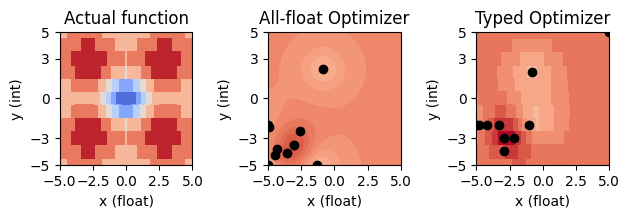

In [7]:
x = np.linspace(c_pbounds['x'][0], c_pbounds['x'][1], 1000)
y = np.linspace(c_pbounds['y'][0], c_pbounds['y'][1], 1000)

X, Y = np.meshgrid(x, y)

Z = discretized_function(X, Y)

params = [{'x': x_i, 'y': y_j} for y_j in y for x_i in x]
c_pred = continuous_optimizer._gp.predict(continuous_optimizer._space.params_to_array(params)).reshape(X.shape)
d_pred = discrete_optimizer._gp.predict(discrete_optimizer._space.params_to_array(params)).reshape(X.shape)

vmin = np.min([np.min(Z), np.min(c_pred), np.min(d_pred)])
vmax = np.max([np.max(Z), np.max(c_pred), np.max(d_pred)])

fig, axs = plt.subplots(1, 3)

axs[0].set_title('Actual function')
axs[0].contourf(X, Y, Z, cmap=plt.cm.coolwarm, vmin=vmin, vmax=vmax)


axs[1].set_title(labels[0])
axs[1].contourf(X, Y, c_pred, cmap=plt.cm.coolwarm, vmin=vmin, vmax=vmax)
axs[1].scatter(continuous_optimizer._space.params[:,0], continuous_optimizer._space.params[:,1], c='k')

axs[2].set_title(labels[1])
axs[2].contourf(X, Y, d_pred, cmap=plt.cm.coolwarm, vmin=vmin, vmax=vmax)
axs[2].scatter(discrete_optimizer._space.params[:,0], discrete_optimizer._space.params[:,1], c='k')


def make_plot_fancy(ax: plt.Axes):
    ax.set_aspect("equal")
    ax.set_xlabel('x (float)')
    ax.set_xticks([-5.0, -2.5, 0., 2.5, 5.0])
    ax.set_ylabel('y (int)')
    ax.set_yticks([-5, -3, 0, 3, 5])

for ax in axs:
    make_plot_fancy(ax)

plt.tight_layout()
plt.show()

## 3. Categorical variables


In [21]:
def f1(x1, x2):
    return -1*(x1 - np.sqrt(x1**2 + x2**2) * np.cos(np.sqrt(x1**2 + x2**2))**2 + 0.5 * np.sqrt(x1**2 + x2**2))

def f2(x1, x2):
    return -1*(x2 - np.sqrt(x1**2 + x2**2) * np.sin(np.sqrt(x1**2 + x2**2))**2 + 0.5 * np.sqrt(x1**2 + x2**2))

def SPIRAL(x1, x2, k):
    """cf Ladislav-Luksan
    """
    if k=='1':
        return f1(x1, x2)
    elif k=='2':
        return f2(x1, x2)


In [22]:
pbounds = {'x1': (-10, 10), 'x2': (-10, 10), 'k': ('1', '2')}

categorical_optimizer = BayesianOptimization(
    f=SPIRAL,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

categorical_optimizer.maximize(
        init_points=2,
        n_iter=18,
        kappa=2.
    )

|   iter    |  target   |     k     |    x1     |    x2     |
-------------------------------------------------------------
| 1         | 8.698     |     2     | -9.998    | -3.953    |
| 2         | 6.796     |     1     | -6.275    | -3.089    |
| 3         | 7.978     |     2     | -9.97     | -3.781    |
| 4         | 10.21     |     2     | -10.0     | -4.999    |
| 5         | -14.69    |     1     | 9.182     | 6.094     |
| 6         | 15.21     |     2     | -5.001    | -10.0     |
| 7         | 2.929     |     1     | -10.0     | -10.0     |
| 8         | 2.288     |     1     | -0.2839   | -10.0     |
| 9         | 10.01     |     1     | -5.544    | -7.449    |
| 10        | -2.929    |     2     | -10.0     | 10.0      |
| 11        | 17.07     |     2     | 10.0      | -10.0     |
| 12        | 3.042     |     2     | 10.0      | -6.849    |
| 13        | 3.855     |     2     | 7.475     | -9.986    |
| 14        | 9.141     |     2     | -6.365    | -10.0     |
| 15    

In [23]:
res = categorical_optimizer._space.res()
k1 = np.array([[p['params']['x1'], p['params']['x2']] for p in res if p['params']['k']=='1'])
k2 = np.array([[p['params']['x1'], p['params']['x2']] for p in res if p['params']['k']=='2'])

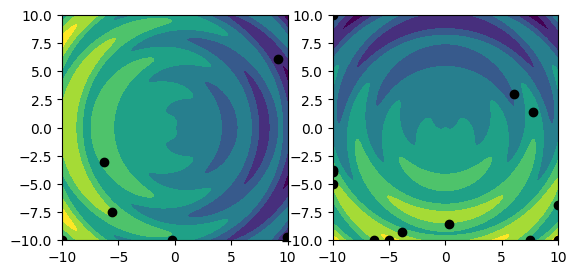

In [24]:
x1 = np.linspace(pbounds['x1'][0], pbounds['x1'][1], 1000)
x2 = np.linspace(pbounds['x2'][0], pbounds['x2'][1], 1000)

X1, X2 = np.meshgrid(x1, x2)
Z1 = SPIRAL(X1, X2, '1')
Z2 = SPIRAL(X1, X2, '2')

fig, axs = plt.subplots(1, 2)

vmin = np.min([np.min(Z1), np.min(Z2)])
vmax = np.max([np.max(Z1), np.max(Z2)])

axs[0].contourf(X1, X2, Z1, vmin=vmin, vmax=vmax)
axs[0].set_aspect("equal")
axs[0].scatter(k1[:,0], k1[:,1], c='k')
axs[1].contourf(X1, X2, Z2, vmin=vmin, vmax=vmax)
axs[1].scatter(k2[:,0], k2[:,1], c='k')
axs[1].set_aspect("equal")


## 4. Saving, loading and restarting

By default you can follow the progress of your optimization by setting `verbose>0` when instanciating the `BayesianOptimization` object. If you need more control over logging/alerting you will need to use an observer. For more information about observers checkout the advanced tour notebook. Here we will only see how to use the native `JSONLogger` object to save to and load progress from files.

### 4.1 Saving progress

In [12]:
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

The observer paradigm works by:
1. Instantiating an observer object.
2. Tying the observer object to a particular event fired by an optimizer.

The `BayesianOptimization` object fires a number of internal events during optimization, in particular, everytime it probes the function and obtains a new parameter-target combination it will fire an `Events.OPTIMIZATION_STEP` event, which our logger will listen to.

**Caveat:** The logger will not look back at previously probed points.

In [13]:
logger = JSONLogger(path="./logs.json")
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

In [14]:
optimizer.maximize(
    init_points=2,
    n_iter=3,
)

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
| 11        | 0.379     | -3.532    | -4        |
| 12        | 0.5579    | -3.137    | -2        |
| 13        | -0.08256  | 4.97      | -5        |
| 14        | -0.08628  | -4.998    | 5         |
| 15        | -0.3398   | 5.0       | 0         |


### 4.2 Loading progress

Naturally, if you stored progress you will be able to load that onto a new instance of `BayesianOptimization`. The easiest way to do it is by invoking the `load_logs` function, from the `util` submodule.

In [15]:
from bayes_opt.util import load_logs

In [16]:
new_optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds={"x": (-2, 2), "y": (-2, 2)},
    verbose=2,
    random_state=7,
)
print(len(new_optimizer.space))

NameError: name 'black_box_function' is not defined

In [ ]:
load_logs(new_optimizer, logs=["./logs.json"]);

In [ ]:
print("New optimizer is now aware of {} points.".format(len(new_optimizer.space)))

In [ ]:
new_optimizer.maximize(
    init_points=0,
    n_iter=10,
)

## Next Steps

This tour should be enough to cover most usage scenarios of this package. If, however, you feel like you need to know more, please checkout the `advanced-tour` notebook. There you will be able to find other, more advanced features of this package that could be what you're looking for. Also, browse the examples folder for implementation tips and ideas.